In [1]:
import cv2
import torch
import utils
import numpy as np

from PIL import Image
from models import gazenet
from mtcnn import FaceDetector
from mtcnn.visualization_utils import show_bboxes

import matplotlib.pyplot as plt

### Use GPU if available. If not, run on CPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load test image
This MTCNN implementation runs on PIL images

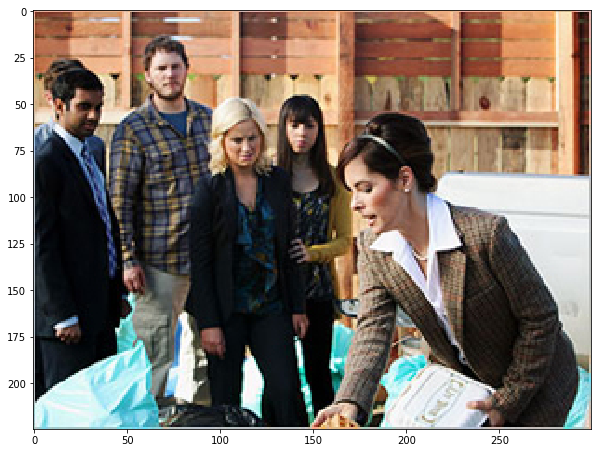

In [3]:
image = Image.open("imgs/parks.jpg")

plt.figure(figsize=(10,10))
plt.imshow(image)

### Load MTCNN Face Detector, find face bounding boxes and landmarks

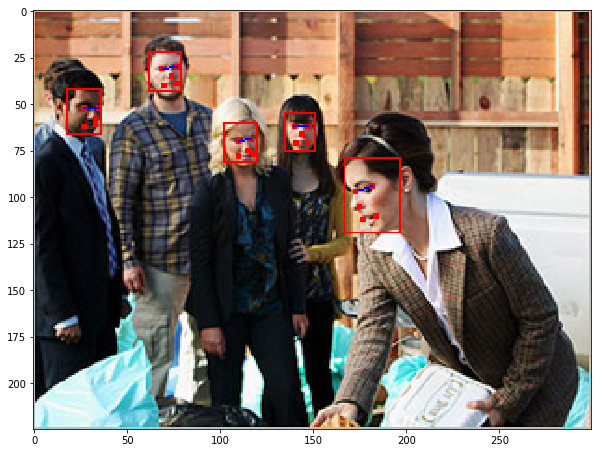

In [6]:
face_detector = FaceDetector(device=device)
bboxes, landmarks = face_detector.detect(image)
image_bboxes = show_bboxes(image, bboxes, landmarks, width=1, eyeline=True)

plt.figure(figsize=(10,10))
plt.imshow(image_bboxes)

### Normalize detected faces for scale and rotation. 
The normalization algorithm scales images to standard 112x112 resolution and attempts to rotate the face as to straighten the line between the left and right eyes.



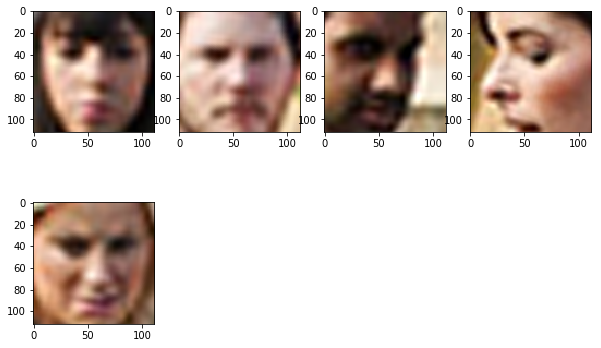

In [7]:
fig=plt.figure(figsize=(10, 10))
rows = np.ceil(np.sqrt(len(bboxes)))
columns = rows + 1
plot_idx = 1
faces, origins = [],[]
for bbox, lm in zip(bboxes, landmarks):
    # Detection confidence check
    if(bbox[-1] > 0.98):
        # Crop and normalize face
        face, gaze_origin, M  = utils.normalize_face(lm, np.asarray(image))
        faces.append(face)
        origins.append(gaze_origin)
        fig.add_subplot(rows, columns, plot_idx)
        plt.imshow(face)
        plot_idx += 1

### Load gaze estimation network and trained weights

In [8]:
model = gazenet.GazeNet(device)
state_dict = torch.load('models/weights/gazenet.pth', map_location=device)
model.load_state_dict(state_dict)
print('Loaded model on {}'.format(device))

Loaded model on cuda:0


### Draw gaze projection arrows for the estimated gaze angles
Usually the normalization and projection should be done in a single loop, but for demonstration purposes I have separated them

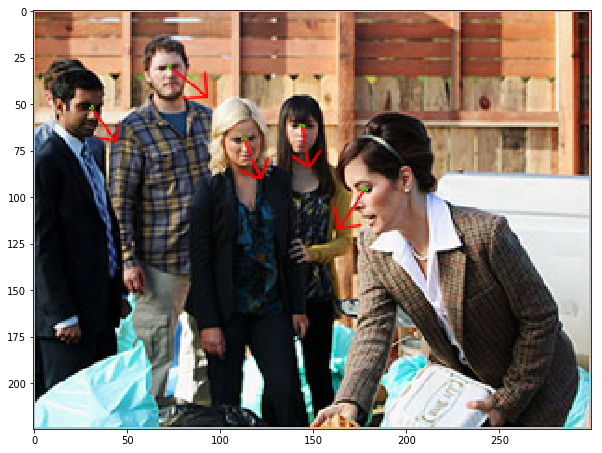

In [9]:
display = np.asarray(image)
for face, gaze_origin in zip(faces, origins):
    # Predict gaze
    with torch.no_grad():
        gaze = model.get_gaze(face)
        gaze = gaze[0].data.cpu()
        display = cv2.circle(display, gaze_origin, 1, (0, 255, 0), -1)            
        display = utils.draw_gaze(display, gaze_origin, gaze, length=100, color=(255,0,0), thickness=1)

fig=plt.figure(figsize=(10, 10))
plt.imshow(display)